<a id="top"></a>
[Go to the bottom](#bottom)
---

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
from zipfile import ZipFile

from datetime import datetime

## Get dataset

In [2]:
DATA_PATH = os.path.join(os.getcwd(), 'data')
FILE_PATH_SEATTLE = os.path.join(DATA_PATH, 'seattle.zip')
FILE_PATH_BOSTON = os.path.join(DATA_PATH, 'boston.zip')

In [3]:
def extract_df_from_airbnb_zipfile(PATH_ZIPFILE) :
    '''
        INPUT : file path to a zipfile to open
        OUTPUT : a dictionary that contains dataframes of files 
        extracted from the zip file
    '''

    zf = ZipFile(PATH_ZIPFILE) 
    dfs = {
        text_file.filename : pd.read_csv(zf.open(text_file.filename ))
        for text_file in zf.infolist() 
        if text_file.filename.endswith('.csv')
    }
    
    print('Printing a dictionary with filenames as keys')
    for filename in dfs.keys() :
        print(f'Filename (keys): {filename}')
    
    return dfs

In [4]:
dfs_sea = extract_df_from_airbnb_zipfile(FILE_PATH_SEATTLE)

Printing a dictionary with filenames as keys
Filename (keys): calendar.csv
Filename (keys): listings.csv
Filename (keys): reviews.csv


In [5]:
listings_sea = dfs_sea['listings.csv']
reviews_sea = dfs_sea['reviews.csv']
calendar_sea = dfs_sea['calendar.csv']

---
## Data exploration
The respective Airbnb datasets are downloaded from : 

- Seattle : https://www.kaggle.com/airbnb/seattle
- Boston  : https://www.kaggle.com/airbnb/boston



### Content
- Listings, including full descriptions and average review score
- Reviews, including unique id for each reviewer and detailed comments
- Calendar, including listing id and the price and availability for that day

### Inspiration
- Can you describe the vibe of each Seattle neighborhood using listing descriptions?
- What are the busiest times of the year to visit Seattle? By how much do prices spike?
- Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?

Reference to the real use of the data: http://insideairbnb.com/seattle/

## `1.` Occupancy rate & price through the year
Working with **`calendar`** dataframe

### Data cleaning

In [6]:
# Copy a dataframe for data cleaning
calendar = calendar_sea.copy() 

In [7]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [ ]:
# Data for 365 days from 2016-01-04 - 2017-01-02
len(calendar.date.value_counts().index) 

In [8]:
# Convert t, f to binary int : available
calendar.available = calendar.available.map({'t': 1, 'f': 0}).astype(int)

In [9]:
# Remove $ & , sign from price
rep = {'$':'', ',':''}

for old, new in rep.items() :
    calendar.price = calendar.price.str.replace(old, new)

In [10]:
# Converting object to float : price
calendar.price = calendar.price.astype(float)

In [11]:
# Occpancy rate and price per day 
matrix_occ_price = calendar.groupby('date').mean().drop(columns='listing_id')
matrix_occ_price.columns = ['occ_rate', 'avg_rate']
matrix_occ_price.describe()

,occ_rate,avg_rate
count,365.000000,365.000000
mean,0.670610,137.901783
std,0.047899,9.860142
min,0.454426,117.685413
25%,0.647197,132.446443
50%,0.674961,136.731206
75%,0.702462,146.930502
max,0.765322,157.480000


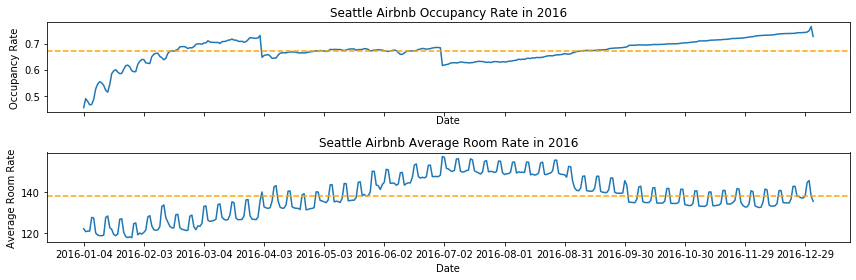

In [12]:
ticks = np.arange(0, len(matrix_occ_price.index)+1, 30)
labels = [matrix_occ_price.index[idx] for idx in ticks]

date = matrix_occ_price.index
rate_dict = [{'data': matrix_occ_price.occ_rate, 'desc': 'Occupancy Rate'},
             {'data': matrix_occ_price.avg_rate, 'desc': 'Average Room Rate'}]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12,4))

for i in [0, 1] : 
    axes[i].plot(date, rate_dict[i]['data'])
    axes[i].set_title('Seattle Airbnb ' + rate_dict[i]['desc'] + ' in 2016')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(rate_dict[i]['desc'])
    axes[i].set_xticks(labels) 
    axes[i].axhline(rate_dict[i]['data'].mean(), ls='--', color='orange', lw=1.5)
    
    fig.tight_layout()

plt.show()

The plots show the overall trend but not clearly in details. Let's break down the date into year, month and day

In [13]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   listing_id  1393570 non-null  int64  
 1   date        1393570 non-null  object 
 2   available   1393570 non-null  int64  
 3   price       934542 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 42.5+ MB


In [14]:
# Convert into datetime object : date
date_conversion = lambda x : datetime.strptime(x, "%Y-%m-%d")
calendar.date = calendar.date.apply(date_conversion)

In [15]:
calendar.insert(2, 'year', calendar.date.apply(lambda x : x.year))
calendar.insert(3, 'month', calendar.date.apply(lambda x : x.month))
calendar.insert(4, 'day', calendar.date.apply(lambda x : x.day))

### Occupancy rate and average room rate in 2016
AirBnb Seattle

In [19]:
monthly_occ_price = calendar.groupby('month').mean()[['available', 'price']]
monthly_occ_price.head()

,available,price
month,,
1,0.566937,122.912176
2,0.662208,124.293927
3,0.709187,128.644488
4,0.663847,135.097005
5,0.675670,139.538183


In [20]:
# Mapping into more intuitive names
monthly_occ_price.index = monthly_occ_price.index.map({
    1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
    7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'
})

monthly_occ_price.columns = ['occ_rate', 'avg_rate']
monthly_occ_price.describe()

,occ_rate,avg_rate
count,12.000000,12.000000
mean,0.670405,137.828177
std,0.044442,9.517936
min,0.566937,122.912176
25%,0.657919,133.483876
50%,0.674393,137.141887
75%,0.699682,144.310246
max,0.735573,152.094150


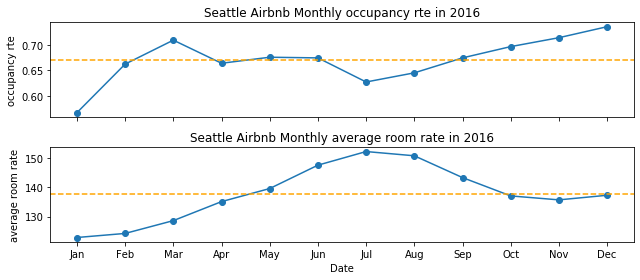

In [30]:
date = monthly_occ_price.index
rate_dict = [{'data': monthly_occ_price.occ_rate, 'desc': 'occupancy rte'},
             {'data': monthly_occ_price.avg_rate, 'desc': 'average room rate'}]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9,4))

for i in [0, 1] : 
    axes[i].plot(date, rate_dict[i]['data'], marker='o')
    axes[i].set_title('Seattle Airbnb Monthly ' + rate_dict[i]['desc'] + ' in 2016')
    axes[i].set_ylabel(rate_dict[i]['desc'])
    axes[i].axhline(rate_dict[i]['data'].mean(), ls='--', color='orange', lw=1.5)


axes[1].set_xlabel('Date')    
fig.tight_layout()

plt.show()

### How about RevPar ? 

RevPAR, or revenue per available room, is a performance metric in the hotel industry that is calculated by dividing a hotel's total guestroom revenue by the room count and the number of days in the period being measured. https://en.wikipedia.org/wiki/RevPAR

It can alternatively be calculated as occupancy rate $(# room occupied / # available) x average room rate$.

In [31]:
monthly_occ_price['rev_par'] = monthly_occ_price.occ_rate * monthly_occ_price.avg_rate

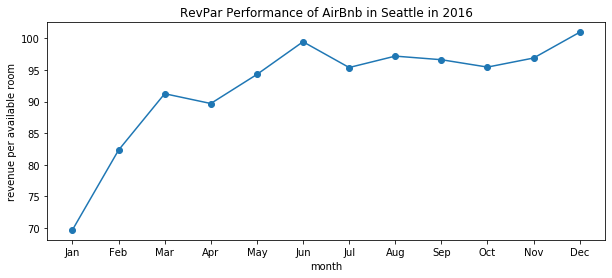

In [34]:
date = monthly_occ_price.index

plt.figure(figsize=(10,4))
plt.plot(date, monthly_occ_price['rev_par'], marker='o')

plt.title('RevPar Performance of AirBnb in Seattle in 2016')
plt.xlabel('month')
plt.ylabel('revenue per available room')

plt.show()

---
## `2`. Trend in listing
Now to discover supply side 

- \# of new hostings : `host_since`
- \# of hostings(at point in time) : `host_listings_count`
- growth of super_host : `host_is_superhost`
- hosting type: [`property_type`, `room_type`, `price`, ...]

---
## `3.` By neighborhood

---
<a id="bottom"></a>
[Go to the top](#top)